# Encoder nach Dennis:

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

mpl.rcParams['figure.figsize'] = (15, 5)

np.random.seed(42)

### Trainingsdata Beispiel (mnist)

In [75]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# add dim b/c of convolution
# scale data from [0,255] to [0,1]
x_train_cnn = x_train[:, :, :, np.newaxis] / 255.0
x_test_cnn = x_test[:, :, :, np.newaxis] / 255.0
x_train_cnn.shape

(60000, 28, 28, 1)

In [76]:
loaded_data1 = np.load("data\spectos.npy")
loaded_data2 = np.load("data\wsPerSong.npy")

loaded_data1 = loaded_data1[..., np.newaxis]
loaded_data1.shape

(47, 128, 21, 1)

### Encoder:

In [64]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(128, 21, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
    tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2),
], name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 64, 11, 32)        544       
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 6, 64)         32832     
                                                                 
 flatten_10 (Flatten)        (None, 12288)             0         
                                                                 
 dense_36 (Dense)            (None, 64)                786496    
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 2)                 130       
                                                                 
Total params: 820,002
Trainable params: 820,002
Non-trainab

In [65]:
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    # we want this layer to have the same dimension as the first dense layer
    # so we can go "backwards" as we have gone "forwards"
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(7*7*64),
    # reshape from a vector to a multidimensional array (image)
    tf.keras.layers.Reshape((7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
    tf.keras.layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', activation='leaky_relu'),
    # back to the 1 dimensional black/white image
    tf.keras.layers.Conv2DTranspose(1, kernel_size=4, strides=1, padding='same', activation='leaky_relu'),
], name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 64)                192       
                                                                 
 dense_39 (Dense)            (None, 3136)              203840    
                                                                 
 reshape_8 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_24 (Conv2D  (None, 14, 14, 64)       65600     
 Transpose)                                                      
                                                                 
 conv2d_transpose_25 (Conv2D  (None, 28, 28, 32)       32800     
 Transpose)                                                      
                                                                 
 conv2d_transpose_26 (Conv2D  (None, 28, 28, 1)        513 

In [66]:
autoencoder = tf.keras.models.Model(encoder.input, decoder(encoder.output), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 128, 21, 1)]      0         
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 11, 32)        544       
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 6, 64)         32832     
                                                                 
 flatten_10 (Flatten)        (None, 12288)             0         
                                                                 
 dense_36 (Dense)            (None, 64)                786496    
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 2)                 

In [77]:
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=lambda y_true, y_pred: K.mean(K.square(y_true - y_pred), axis=[1, 2, 3]),
)

autoencoder.fit(
    #x=x_train_cnn,
    x=loaded_data1,
    # use the input as the target
    #y=x_train_cnn,
    y=loaded_data1,
    batch_size=200,
    shuffle=True,
    epochs=1,
)

ValueError: in user code:

    File "C:\Users\FynnFrei\Documents\GitHub\MetaHuman\venv\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\FynnFrei\AppData\Local\Temp\ipykernel_17216\1807049879.py", line 3, in None  *
        lambda y_true, y_pred: K.mean(K.square(y_true - y_pred), axis=[1, 2, 3])

    ValueError: Dimensions must be equal, but are 128 and 28 for '{{node lambda/sub}} = Sub[T=DT_FLOAT](IteratorGetNext:1, autoencoder/decoder/conv2d_transpose_26/LeakyRelu)' with input shapes: [?,128,21,1], [?,28,28,1].


### Latent space Repräsentation:

In [9]:
latent_represenation = encoder.predict(x_train_cnn)
latent_represenation.shape

(60000, 2)

#### latent_representation ist ein zweidimensionales Array, das die Koordinaten aller Wavesets im Latent space enthält.

NameError: name 'latent_represenation' is not defined

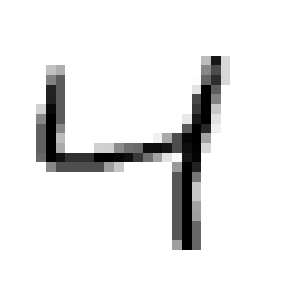

In [79]:
fig, axs = plt.subplots(1, 1, figsize=(5,5))
i = 2
axs.imshow(x_train_cnn[i], cmap='binary')
axs.axis('off')
print(latent_represenation[i])

In [81]:
plt.figure(figsize=(20, 20))
plt.scatter(latent_represenation[:, 0], latent_represenation[:, 1], c=y_train)

NameError: name 'latent_represenation' is not defined

<Figure size 1440x1440 with 0 Axes>